##### Import & Seed:

In [1]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from scipy.integrate import odeint
from scipy.linalg import hankel
from pyDOE import lhs
from scipy.io import savemat
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import train_test_split

from utils_EKFSINDy import add_noise_with_snr, jacobian_A, jacobian_H

from sklearn.linear_model import Lasso
#from pysindy.optimizers import SR3

from Data import SINDy_data
from Data import data
from Data import equations


np.random.seed(999)

todo:  
capire se è possibile migliorare le performance  
just in case: combinazione di parametri

##### Parametrization on $\sigma$

In [2]:
# Select ODE & settings:
ode_name = 'Lorenz_sigma'
ode_param=None
freq = 25
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 3
dim_k = 1
ode = equations.get_ode(ode_name, ode_param)

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 250, 3) (50, 250, 3) (50, 250)
['x1', 'x2', 'x3', 'k']


Threshold:  0.05 , RMSE:  11.52253613085334
Threshold:  0.1 , RMSE:  10.95824523983401
Threshold:  0.2 , RMSE:  11.208744995200226
Threshold:  0.4 , RMSE:  11.558521695482584
Threshold:  0.6 , RMSE:  11.39599685185548
Threshold:  0.8 , RMSE:  10.956203438406998


/Users/grgromano/miniconda3/envs/d-code_gege/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


Threshold:  1.0 , RMSE:  13.750139076101949


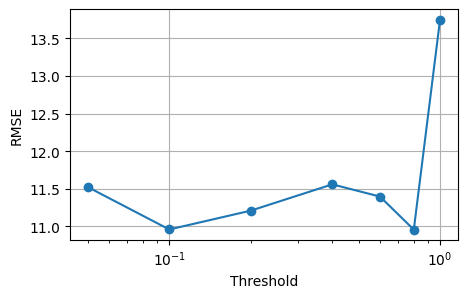

In [4]:
# model selection:
thresholds = np.array([0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [10, 10, 10, 10.5], [0, 0, 0, 9.5])
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)   

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_thresholds: 0.1, 0.8

In [4]:
# best models:
best_threshold_1 = 0.1
model_sigma_1 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold_1))
model_sigma_1.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_sigma_1.print()

best_threshold_2 = 0.8
model_sigma_2 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold_2))
model_sigma_2.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_sigma_2.print()

(x1)' = -13.043 x1 + 9.024 x2 + -0.110 x3 + 59.583 k + 0.310 x1 x3 + -0.417 x1 k + -0.245 x2 x3 + 0.550 x2 k + -11.950 k^2 + 0.598 k^3
(x2)' = -109.964 x1 + 130.274 x2 + -63.698 x3 + 241.966 k + 0.178 x1^2 + -0.104 x1 x2 + -0.309 x1 x3 + 22.621 x1 k + -25.410 x2 k + 12.501 x3 k + -48.006 k^2 + -1.122 x1 k^2 + 1.270 x2 k^2 + -0.617 x3 k^2 + 2.380 k^3
(x3)' = 174.371 x1 + -56.615 x2 + -6.503 x3 + -69.095 k + 1.196 x1^2 + -0.825 x1 x2 + -35.024 x1 k + 0.500 x2^2 + 11.201 x2 k + 0.139 x3 k + 15.571 k^2 + 1.747 x1 k^2 + -0.551 x2 k^2 + -0.806 k^3
(x1)' = -6.727 x1 + 6.756 x2
(x2)' = -8.644 x1 + 6.667 x2 + -0.856 k
(x3)' = -5.329 x3 + 7.015 k + 0.942 x1^2


Best Model 1 RMSE:  10.95824523983401
Best Model 2 RMSE:  10.956203438406998


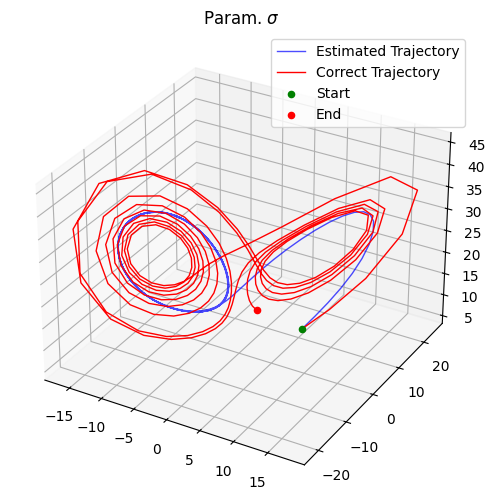

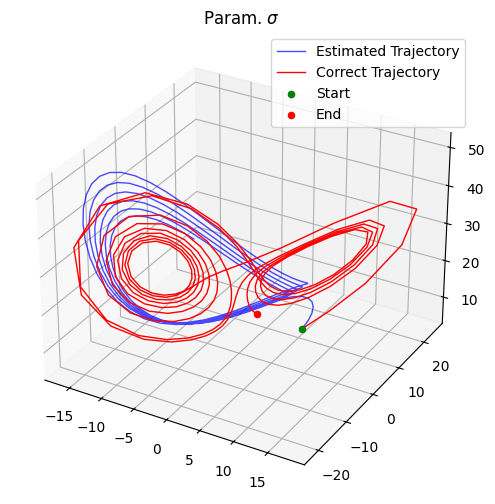

In [5]:
# evaluation:
n_sample = 10
rmse_sigma_1 = SINDy_data.evaluate_RMSE(model_sigma_1, ode, freq, n_sample, [10, 10, 10, 10.5], [0, 0, 0, 9.5])
print('Best Model 1 RMSE: ', rmse_sigma_1)
rmse_sigma_2 = SINDy_data.evaluate_RMSE(model_sigma_2, ode, freq, n_sample, [10, 10, 10, 10.5], [0, 0, 0, 9.5])
print('Best Model 2 RMSE: ', rmse_sigma_2)
n_sample = 1
init_point = [5, 5, 5, 10.0]
title = r'Param. $\sigma$'
SINDy_data.evaluate_traj(model_sigma_1, ode, freq, n_sample, init_point, init_point, dim_x, title=title)
SINDy_data.evaluate_traj(model_sigma_2, ode, freq, n_sample, init_point, init_point, dim_x, title=title)


##### Parametrization on $\rho$

In [6]:
# Select ODE & settings:
ode_name = 'Lorenz_rho'
ode_param=None
freq = 50
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 3
dim_k = 1
ode = equations.get_ode(ode_name, ode_param)
# init_high = [5, 5, 5, 28.0]

In [7]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 500, 3) (50, 500, 3) (50, 500)
['x1', 'x2', 'x3', 'k']


Threshold:  0.05 , RMSE:  11.237219275624238
Threshold:  0.1 , RMSE:  11.076672435429924
Threshold:  0.2 , RMSE:  11.55332119691406
Threshold:  0.4 , RMSE:  12.018058322238868
Threshold:  0.6 , RMSE:  11.727485978250046


/Users/grgromano/miniconda3/envs/d-code_gege/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.8) and eliminated all coefficients
  warnings.warn(


Threshold:  0.8 , RMSE:  14.573551106679588


/Users/grgromano/miniconda3/envs/d-code_gege/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


Threshold:  1.0 , RMSE:  14.573551106679588


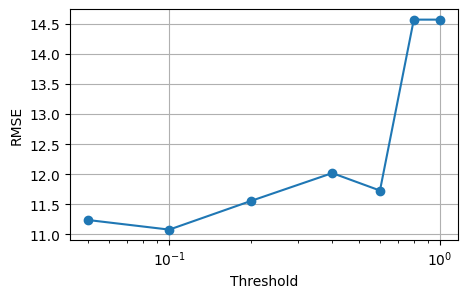

In [8]:
# model selection:
thresholds = np.array([0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [10, 10, 10, 28.5], [0, 0, 0, 27.5])
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)   

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_thresholds: 0.1

In [8]:
# best models:
best_threshold_1 = 0.1
model_rho_1 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold_1))
model_rho_1.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_rho_1.print()

best_threshold_2 = 0.5
model_rho_2 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold_2))
model_rho_2.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_rho_2.print()

# Lasso does not work: model_2 = ps.SINDy(feature_names = feature_names, feature_library= ps.PolynomialLibrary(degree = 3, include_bias=False), optimizer=Lasso(alpha=0.0001))

(x1)' = -14.481 x1 + 13.209 x2 + 0.213 x1 x3 + -0.184 x2 x3
(x2)' = -7.899 x1 + 2.803 x2 + -0.125 k + -0.440 x1 x3 + 0.575 x1 k
(x3)' = -0.779 x1 + -5.192 x2 + -261.866 x3 + 1.952 k + 1.085 x1^2 + -0.558 x1 x2 + 0.415 x2^2 + 0.188 x2 k + 18.231 x3 k + -0.324 x3 k^2
(x1)' = -7.573 x1 + 7.594 x2
(x2)' = -9.305 x1 + 7.666 x2
(x3)' = -5.881 x3 + 2.741 k + 1.048 x1^2


Best Model 1 RMSE:  11.076672435429924
Best Model 2 RMSE:  11.727485978250046


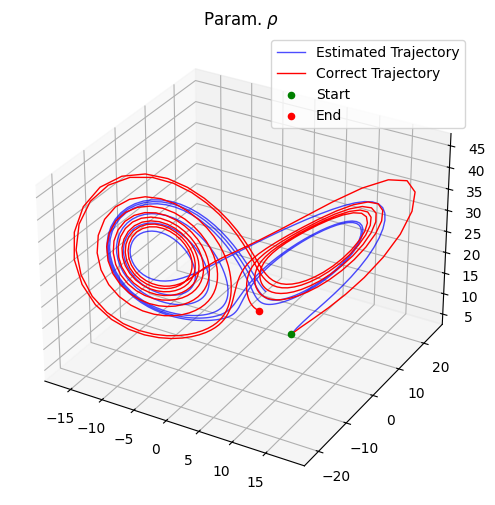

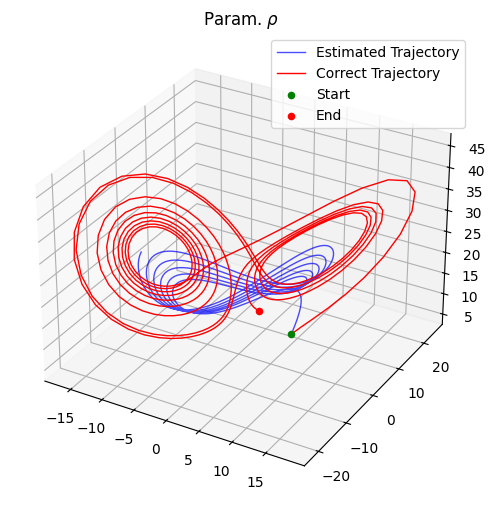

In [9]:
# evaluation:
n_sample = 10
rmse_rho_1 = SINDy_data.evaluate_RMSE(model_rho_1, ode, freq, n_sample, [10, 10, 10, 28.5], [0, 0, 0, 27.5])
print('Best Model 1 RMSE: ', rmse_rho_1)
rmse_rho_2 = SINDy_data.evaluate_RMSE(model_rho_2, ode, freq, n_sample, [10, 10, 10, 28.5], [0, 0, 0, 27.5])
print('Best Model 2 RMSE: ', rmse_rho_2)
n_sample = 1
init_point = [5, 5, 5, 28.0]
title = r'Param. $\rho$'
SINDy_data.evaluate_traj(model_rho_1, ode, freq, n_sample, init_point, init_point, dim_x, title=title)
SINDy_data.evaluate_traj(model_rho_2, ode, freq, n_sample, init_point, init_point, dim_x, title=title)

##### Parametrization on $\beta$

In [10]:
# Select ODE & settings:
ode_name = 'Lorenz_beta'
ode_param=None
freq = 50
dt = 1 / freq
n_sample = 50 
noise_ratio = 0.01
dim_x = 3
dim_k = 1
ode = equations.get_ode(ode_name, ode_param)
# init_high = [5, 5, 5, 8/3]

In [11]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 500, 3) (50, 500, 3) (50, 500)
['x1', 'x2', 'x3', 'k']


Threshold:  0.05 , RMSE:  11.915591559195288
Threshold:  0.1 , RMSE:  12.230200314021205
Threshold:  0.2 , RMSE:  11.239065887446694
Threshold:  0.4 , RMSE:  10.999291302322927
Threshold:  0.6 , RMSE:  65.75258799259265


/Users/grgromano/miniconda3/envs/d-code_gege/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.8) and eliminated all coefficients
  warnings.warn(


Threshold:  0.8 , RMSE:  20.431656175943058


/Users/grgromano/miniconda3/envs/d-code_gege/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


Threshold:  1.0 , RMSE:  11.837459033595065


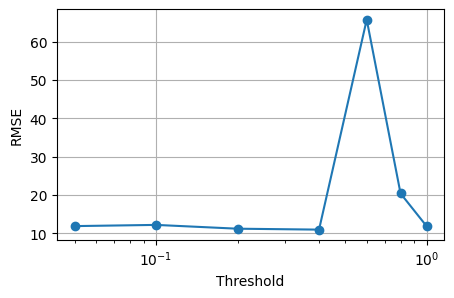

In [14]:
# model selection:
thresholds = np.array([0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
    rmse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, [10, 10, 10, 9/3], [0, 0, 0, 7/3])
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)   

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

# -> best_thresholds:

In [12]:
# best models:
best_threshold_1 = 0.2
model_beta_1 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold_1))
model_beta_1.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_beta_1.print()

best_threshold_2 = 0.4
model_beta_2 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=best_threshold_2))
model_beta_2.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
model_beta_2.print()

# other models:
# Lasso does not converge: model_2 = ps.SINDy(feature_names = feature_names, feature_library= ps.PolynomialLibrary(degree = 3, include_bias=False), optimizer=Lasso(alpha=0.5))
# OrthogonalMatchingPursuit very low performance: from sklearn.linear_model import OrthogonalMatchingPursuit, model_2= ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=OrthogonalMatchingPursuit())
# Sequentially Thresholded Ridge Regression, niente di che: model_2 = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=False), optimizer=ps.STLSQ(threshold=0.08, alpha=1.0))

(x1)' = -7.568 x1 + 7.586 x2
(x2)' = 7.455 x1 + 25.081 k + -0.437 x1 x3 + 0.225 x1 k + 2.469 x2 k + -20.242 k^2 + -0.522 x2 k^2 + 3.848 k^3
(x3)' = 21.821 x1 + -4.154 x2 + -2.223 x3 + 41.808 k + 1.101 x1^2 + -0.576 x1 x2 + -16.788 x1 k + 0.421 x2^2 + 2.996 x2 k + -1.090 x3 k + -7.792 k^2 + 3.102 x1 k^2 + -0.533 x2 k^2
(x1)' = -7.568 x1 + 7.586 x2
(x2)' = 11.273 x1 + 29.832 k + -0.439 x1 x3 + -1.138 x1 k + 1.025 x2 k + -23.801 k^2 + 4.511 k^3
(x3)' = 21.821 x1 + -4.154 x2 + -2.223 x3 + 41.808 k + 1.101 x1^2 + -0.576 x1 x2 + -16.788 x1 k + 0.421 x2^2 + 2.996 x2 k + -1.090 x3 k + -7.792 k^2 + 3.102 x1 k^2 + -0.533 x2 k^2


Best Model 1 RMSE:  11.239065887446694
Best Model 2 RMSE:  10.999291302322927


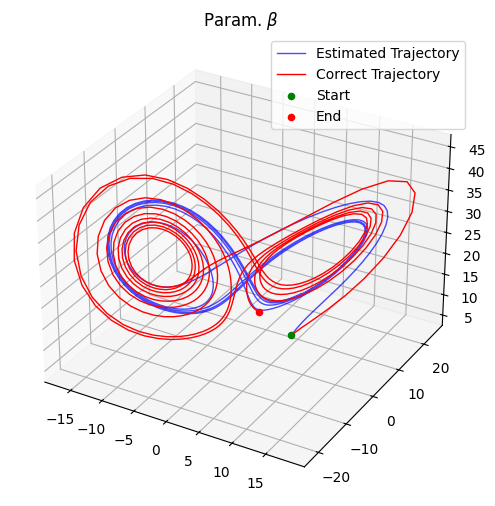

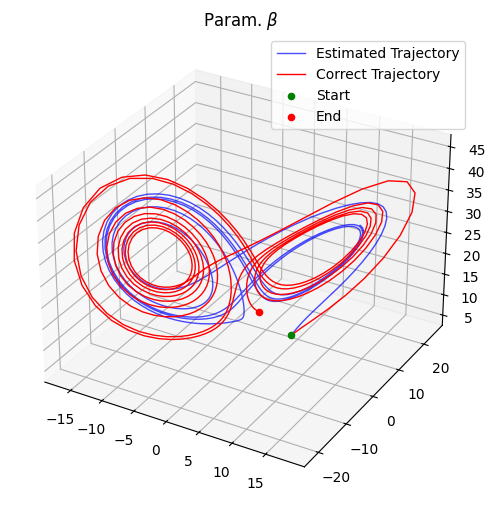

In [13]:
# evaluation:
n_sample = 10
rmse_beta_1 = SINDy_data.evaluate_RMSE(model_beta_1, ode, freq, n_sample, [10, 10, 10, 9/3], [0, 0, 0, 7/3])
print('Best Model 1 RMSE: ', rmse_beta_1)
rmse_beta_2 = SINDy_data.evaluate_RMSE(model_beta_2, ode, freq, n_sample, [10, 10, 10, 9/3], [0, 0, 0, 7/3])
print('Best Model 2 RMSE: ', rmse_beta_2)
n_sample = 1
init_point = [5, 5, 5, 8/3]
title = r'Param. $\beta$'
SINDy_data.evaluate_traj(model_beta_1, ode, freq, n_sample, init_point, init_point, dim_x, title=title)
SINDy_data.evaluate_traj(model_beta_2, ode, freq, n_sample, init_point, init_point, dim_x, title=title)

##### Results: 

Parametrization on $\sigma$:  
In this setting, SINDy is not able to identify the correct model -> RMSE~=10.9. The obtained trajectory does not follow consistently the correct one.

Parametrization on $\rho$:  
Also in this case, the estimated model is far from the correct one -> RMSE~=11.1. The obtained trajectory somehow follows the 'butterly attractor', even if it is very inprecise.

Parametrization on $\beta$:  
Similar to case $\rho$.



##### dev:

In [8]:
# trajectory estimation:   

# true trajectory:
dg_true = data.DataGenerator(ode, ode.T, freq, n_sample=1, noise_sigma=0., init_high=[5, 5, 5, 8/3], init_low=[5, 5, 5, 8/3])
xt_true = dg_true.xt

#estimated trajectory:
correct_param = 8/3
t = np.arange(0,ode.T,dt)
T_plot = len(t)
test_params = np.tile(correct_param, (T_plot,1))
pred_0 = model_0.simulate(xt_true[0, 0, :][:-dim_k], t= t[:T_plot], u = test_params)
pred_1 = model_1.simulate(xt_true[0, 0, :][:-dim_k], t= t[:T_plot], u = test_params)
#pred_2 = model_2.simulate(xt_true[0, 0, :][:-dim_k], t= t[:T_plot], u = test_params)

xt_true = xt_true[:len(pred_0), :, :]
xt_true = xt_true[:, :, :-dim_k]
xt_true = xt_true.squeeze()
print(np.shape(xt_true))
print(np.shape(pred_0))
print(np.shape(pred_1))
#print(np.shape(pred_2))

(499, 3)
(499, 3)
(499, 3)


Model 0 RMSE:  11.04456752988756
Model 1 RMSE:  10.31910597873186


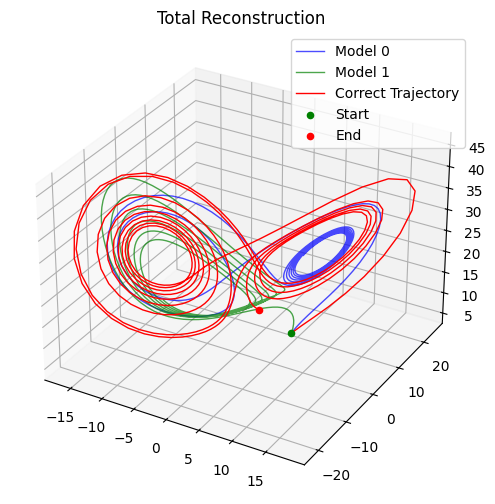

In [9]:
# RMSE:
rmse_0 = root_mean_squared_error(xt_true, pred_0) 
print('Model 0 RMSE: ', rmse_0)
rmse_1 = root_mean_squared_error(xt_true, pred_1)
print('Model 1 RMSE: ', rmse_1)
# rmse_2 = root_mean_squared_error(xt_true, pred_2)
# print('Model 2 RMSE: ', rmse_2)

# 3D-plot:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': '3d'})

ax.plot(pred_0[:, 0], pred_0[:, 1], pred_0[:, 2], color='blue', linewidth=1.0, alpha=0.7, label='Model 0')
ax.plot(pred_1[:, 0], pred_1[:, 1], pred_1[:, 2], color='green', linewidth=1.0, alpha=0.7, label='Model 1')
#ax.plot(pred_2[:, 0], pred_2[:, 1], pred_2[:, 2], color='cyan', linewidth=1.0, alpha=0.7, label='Model 2')

ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2], color='red', linewidth=1.0, label='Correct Trajectory')
ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label='Start')
ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label='End')

ax.set_title('Total Reconstruction')
ax.legend()
ax.grid(True) 